# Train the DriveSafe model with RNN (LSTM)

- Takes fixed-length video snippets as inputs and produces a label output
- Driving simulator [here](https://www.crazygames.com/game/city-car-driving-simulator)
- Built based on this [towardsdatascience article](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
# from IPython.display import HTML

InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# import the necessary packages
import numpy as np
import os
import argparse
import pickle
from utils.data import get_sequence_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten
from tensorflow.keras.applications import ResNet50
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Configurations

In [4]:
# config vars

DATASET_PATH = "data"
OUTPUT_PATH = "model"
FRAMES_PER_SEQ = 30
LABELS = set(["collision", "safe", "tailgating", "weaving"])

NUM_EPOCHS = 25 #150
BATCH_SIZE = 32 #2048
PATIENCE = 50

# Load Input Data

In [5]:
# load sequence data
print("[INFO] loading sequence data...")
data, labels = get_sequence_data(DATASET_PATH, LABELS, FRAMES_PER_SEQ)

# convert the data and labels to numpy arrays
training_data = np.array(data["training"])
training_labels = np.array(labels["training"])
validation_data = np.array(data["validation"])
validation_labels = np.array(labels["validation"])

# count number of sequences
print(f"[INFO] number of sequences in training_data: {len(training_data)}")
print(f"[INFO] number of sequences in validation_data: {len(validation_data)}")

# perform one-hot encoding on the labels
lb = LabelBinarizer()
training_labels = lb.fit_transform(training_labels)
validation_labels = lb.transform(validation_labels) # use transform instead of fit_transform because we want to use the same encoder as the training data

[INFO] loading sequence data...
[INFO] number of sequences in training_data: 246
[INFO] number of sequences in validation_data: 24


# Chunk and Reshape Data
We want to reshape trainX like this: (num_sequences, FRAMES_PER_SEQ, 224, 224, 3) --> (num_sequences, FRAMES_PER_SEQ, IMAGE_DATA)

In [6]:
# partition the data into training and testing splits
# (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)
trainX = training_data
testX = validation_data
trainY = training_labels
testY = validation_labels

# Load ResNet50 model without the top layer
resnet50_model = ResNet50(weights="imagenet", include_top=False)
def preprocess_sequence(sequence):
    # Preprocess each image in the sequence and extract features using ResNet50
    features_sequence = [resnet50_model.predict(np.expand_dims(img, axis=0)) for img in sequence]
    return features_sequence


# trainX has the shape (num_sequences, FRAMES_PER_SEQ, 224, 224, 3)
# trainX = trainX.reshape(trainX.shape[0], FRAMES_PER_SEQ, -1)  # Reshaping each sequence of N frames into a single time step
# testX = testX.reshape(testX.shape[0], FRAMES_PER_SEQ, -1) # equiv to saying `testX.reshape(NUM_SEQUENCES_IN_TEST_X, FRAMES_PER_SEQ, -1)`
trainX_resnet = [preprocess_sequence(sequence) for sequence in trainX]
testX_resnet = [preprocess_sequence(sequence) for sequence in testX]

# Train the Model

In [7]:
# initialize the model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(len(lb.classes_), activation="softmax"))

# callbacks
# patience sets how many epochs to run for before stopping (if no more improvements are made)
callbacks = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
             ModelCheckpoint(os.path.join(OUTPUT_PATH, 'checkpoint.keras'), save_best_only=True, save_weights_only=False)]

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# train the model
print("[INFO] training model...")
history = model.fit(trainX, trainY, validation_data=(testX, testY), callbacks=callbacks, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
NUM_EPOCHS = len(history.history['loss'])

[INFO] training model...


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3171 - loss: 1.4667 - val_accuracy: 0.2500 - val_loss: 1.3535
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.2439 - loss: 1.6447 - val_accuracy: 0.2500 - val_loss: 1.4222
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2886 - loss: 1.5243 - val_accuracy: 0.2917 - val_loss: 1.4465
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2724 - loss: 1.4937 - val_accuracy: 0.2500 - val_loss: 1.4512
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2480 - loss: 1.5647 - val_accuracy: 0.2500 - val_loss: 1.4552
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2724 - loss: 1.5758 - val_accuracy: 0.2500 - val_loss: 1.4522
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2602 - loss: 1.5065 - val_accuracy: 0.2500 - val_loss: 1.4494
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3211 - loss: 1.5140 - val_accuracy: 0.2500 - val_loss: 1.4468
Epoc

# Evaluate the Model

[INFO] evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
              precision    recall  f1-score   support

   collision       0.26      1.00      0.41         6
        safe       0.00      0.00      0.00         6
  tailgating       0.00      0.00      0.00         6
     weaving       0.00      0.00      0.00         6

    accuracy                           0.25        24
   macro avg       0.07      0.25      0.10        24
weighted avg       0.07      0.25      0.10        24



/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Training Loss and Accuracy')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Loss/Accuracy')

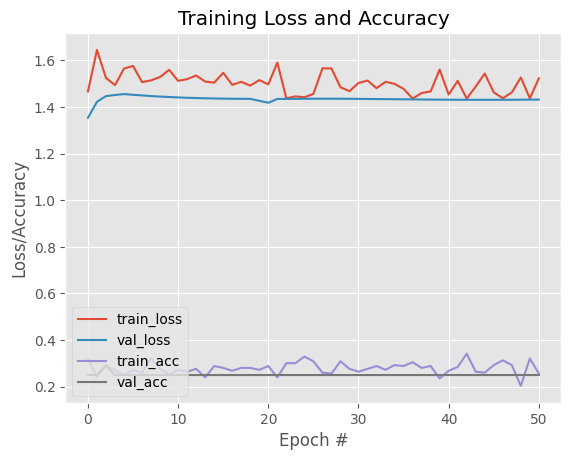

In [8]:
# evaluate the model
print("[INFO] evaluating model...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(os.path.join(OUTPUT_PATH, "plot.png"))

# Save Output to Disk

In [9]:
# serialize the model to disk
print("[INFO] serializing model...")
model.save(os.path.join(OUTPUT_PATH, "model.keras"))

# serialize the label binarizer to disk
with open(os.path.join(OUTPUT_PATH, "labels.pickle"), "wb") as f:
    f.write(pickle.dumps(lb))

[INFO] serializing model...


483